# Business Problem

A empresa Top Bank atua na Europa tendo como principal produto uma conta bancária. Este produto pode manter o salário do cliente e efetuar pagamentos. Essa conta não tem nenhum custo nos primeiros 12 meses, porém, após esse período, o cliente precisa recontratar o banco para os próximos 12 meses e refazer esse processo todos os anos. Recentemente, a equipe de análise notou que a taxa de churn está aumentando.

## Challenge:
Como Cientista de Dados, você precisa criar um plano de ação para diminuir o número de clientes churn e mostrar o retorno financeiro da sua solução.
Além disso, você precisará fornecer um relatório relatando o desempenho de seu modelo e o impacto financeiro de sua solução.
Perguntas que o CEO e a equipe do Analytics gostariam de ver em seu relatório:

1. Qual é a atual taxa de churn do Top Bank?
2. Como a taxa de churn varia mensalmente?
3. Qual é o desempenho do modelo na classificação de clientes como churns?
4. Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

## Note:
Como posso responder os 4 desafios do problema???

    R: Conhecer as variáveis (Data Description) e definir plano de desenvolvimento.

# Imports

In [1]:
#Data Processing
import pandas as pd
import numpy as np

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Data Preparation
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

#Feature Selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

#Model and Metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

#Parameter and Model Saving
import pickle

#Display Jupyter
from IPython.core.display import HTML
from IPython.core.display import Image
import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [2]:
def numeric_descriptive_statistical(numeric_attributes):
    mean = pd.DataFrame(numeric_attributes.apply(np.mean)).T
    median = pd.DataFrame(numeric_attributes.apply(np.median)).T
    standard_deviation = pd.DataFrame(numeric_attributes.apply(np.std)).T
    minimum = pd.DataFrame(numeric_attributes.apply(np.min)).T
    maximum = pd.DataFrame(numeric_attributes.apply(np.max)).T
    distance_between_minimum_and_maximum = pd.DataFrame(numeric_attributes.apply(lambda x: x.max() - x.min())).T
    unique = pd.DataFrame(numeric_attributes.apply(lambda x: len(x.unique()))).T
    skewness = pd.DataFrame(numeric_attributes.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(numeric_attributes.apply(lambda x: x.kurtosis())).T
    

    #concatenate
    vizualizer_descriptive_statistical = pd.concat([minimum, maximum, distance_between_minimum_and_maximum, unique, mean, median, standard_deviation, skewness, kurtosis]).T.reset_index()
    vizualizer_descriptive_statistical.columns = ['Variáveis', 'Mínimo', 'Máximo', 'Range', 'Valores Únicos', 'Média', 'Mediana', 'Desv. Padrão', 'Assimetria', 'Curtose']

    return vizualizer_descriptive_statistical

def n_bins(numeric_column):
    n = numeric_column.shape[0]
    k = round(1 + (3.3 * np.log10(n)))    
        
    return k

def show_univariate_numeric_distribution(numeric_column, bins, title, ylabel, xlabel):
    # Get statistics
    min_val = numeric_column.min()
    max_val = numeric_column.max()
    mean_val = numeric_column.mean()
    med_val = numeric_column.median()
    mod_val = numeric_column.mode()[0]
    first_quartile_val= np.percentile(numeric_column, 25)
    third_quartile_val = np.percentile(numeric_column, 75)
    
    print('Mínimo:{:.2f}\nMédia:{:.2f}\nMediana:{:.2f}\nModa:{:.2f}\nMáximo:{:.2f}\nPrimeiro Quartil:{:.2f}\nTerceiro Quartil:{:.2f}'.format(min_val, mean_val,
                                                                                                                                             med_val, mod_val, max_val,
                                                                                                                                             first_quartile_val,
                                                                                                                                             third_quartile_val))

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (14,6))

    # Plot the histogram   
    ax[0].hist(numeric_column, bins= bins, color= 'salmon')
    ax[0].set_ylabel(ylabel)

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=first_quartile_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'green', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=third_quartile_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot   
    ax[1].boxplot(numeric_column, vert=False)
    ax[1].set_xlabel(xlabel)

    # Add a title to the Figure
    fig.suptitle(title)
    
    fig.show()
    
    return  None

sequencial_palette = ['#ffe14d', '#fac04b', '#f59f49', '#f08048', '#eb6246', '#e64545', '#e0435e', '#db4275', '#d6408b', '#d13fa0', '#cc3db4', '#c73cc7']
categorical_palette = ["#fbbd05", "#ff7a5c", "#ff4d4d", "#ff0000", "#c90000"]

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [14, 6]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = 50
    pd.options.display.max_rows= False
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    sns.set_palette(categorical_palette)
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Load Data

In [3]:
data_raw = pd.read_csv('../data/churn.csv')
data_raw

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Data Description

In [4]:
df2 = data_raw.copy()

## Meaning of Data

- **RowNumber**: o número das colunas
- **CustomerID**: identificador único de clientes
- **Surname**: sobrenome do cliente
- **CreditScore**: pontuação de crédito do cliente para o mercado financeiro (quanto maior o score, é um bom pagador)
- **Geography**: o país do cliente
- **Gender**: o gênero do cliente
- **Age**: a idade do cliente
- **Tenure**: número de anos que o cliente está no banco
- **Balance**: o valor que o cliente tem em sua conta
- **NumOfProducts**: o número de produtos que o cliente comprou (no caso, contas)
- **HasCrCard**: se o cliente tiver cartão de crédito
- **IsActiveMember**: se o cliente estiver ativo (nos últimos 12 meses)
- **EstimateSalary**: estimativa de salário anual dos clientes
- **Exited**: se o cliente for churn (*variável resposta*)

## Rename Columns

In [5]:
renamed_columns = ['numero_linha', 'id_cliente', 'sobrenome', 'score_credito', 'geografia', 'genero', 'idade', 'tempo_permanencia', 
                   'saldo', 'numero_de_contas', 'tem_cartao_credito', 'membro_ativo', 'salario_estimado', 'Churn']
df2.columns = renamed_columns

df2.head(1)

,numero_linha,id_cliente,sobrenome,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,Churn
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101348.88,1


## Data Dimensions

In [6]:
data_dimensions = df2.shape
print(f'A base de dados possui {data_dimensions[0]} clientes e {data_dimensions[1]} variáveis.')

A base de dados possui 10000 clientes e 14 variáveis.


## Data Types

In [7]:
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito      int64
membro_ativo            int64
salario_estimado      float64
Churn                   int64
dtype: object

### Change Data Types

In [8]:
#Alterando o tipo de dados das colunas binárias: 'tem_cartao_credito', 'membro_ativo' e 'Churn'
categorical_columns = ['tem_cartao_credito', 'membro_ativo', 'Churn']

for columns in categorical_columns:
    df2[columns] = df2[columns].apply(lambda x: 'yes' if x == 1 else 'no')
    
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito     object
membro_ativo           object
salario_estimado      float64
Churn                  object
dtype: object

## Check Duplicates

In [9]:
df2[df2.duplicated('id_cliente', False)]

,numero_linha,id_cliente,sobrenome,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,Churn


- A base não possui dados duplicados.

## Check NaN and Null Values

In [10]:
#Dados NaN
df2.isna().sum()

numero_linha          0
id_cliente            0
sobrenome             0
score_credito         0
geografia             0
genero                0
idade                 0
tempo_permanencia     0
saldo                 0
numero_de_contas      0
tem_cartao_credito    0
membro_ativo          0
salario_estimado      0
Churn                 0
dtype: int64

In [11]:
#Dados Null
df2.isnull().sum()

numero_linha          0
id_cliente            0
sobrenome             0
score_credito         0
geografia             0
genero                0
idade                 0
tempo_permanencia     0
saldo                 0
numero_de_contas      0
tem_cartao_credito    0
membro_ativo          0
salario_estimado      0
Churn                 0
dtype: int64

- A base não possui dados faltantes.

## Check Zero Values

In [12]:
df2.dtypes

numero_linha            int64
id_cliente              int64
sobrenome              object
score_credito           int64
geografia              object
genero                 object
idade                   int64
tempo_permanencia       int64
saldo                 float64
numero_de_contas        int64
tem_cartao_credito     object
membro_ativo           object
salario_estimado      float64
Churn                  object
dtype: object

In [13]:
#Transfomando valores diferentes de 0 em "another value" em todas as variáveis numéricas
numerical_variables = df2.select_dtypes(include= ['int64', 'float64']).columns
numerical_variables_verify = df2[numerical_variables]

for column in numerical_variables_verify.columns:
    numerical_variables_verify[column] = numerical_variables_verify[column].apply(lambda x: '0' if x == 0 else 'another value')

In [14]:
numerical_variables_verify.apply(lambda x: x.unique())

numero_linha            [another value]
id_cliente              [another value]
score_credito           [another value]
idade                   [another value]
tempo_permanencia    [another value, 0]
saldo                [0, another value]
numero_de_contas        [another value]
salario_estimado        [another value]
dtype: object

- Apenas as variáveis 'tempo_permanencia' e 'saldo' possuem valores declarados como 0.

De fato, apenas as colunas 'score_credito' (dependendo da regra de negócio), 'tempo_permanencia' e 'saldo' fazem sentido terem valores iguais a 0, mas ainda cabe análise.

In [15]:
percentage_0_in_saldo = numerical_variables_verify['saldo'].value_counts()[1] / numerical_variables_verify.shape[0] * 100
percentage_0_in_tenure = numerical_variables_verify['tempo_permanencia'].value_counts()[1] / numerical_variables_verify.shape[0] * 100
print(f'A coluna \'saldo\' possui {percentage_0_in_saldo}% registros zerados')
print(f'A coluna \'tempo_permanencia\' possui {percentage_0_in_tenure:.2f}% registros zerados')

A coluna 'saldo' possui 36.17% registros zerados
A coluna 'tempo_permanencia' possui 4.13% registros zerados


### *saldo*

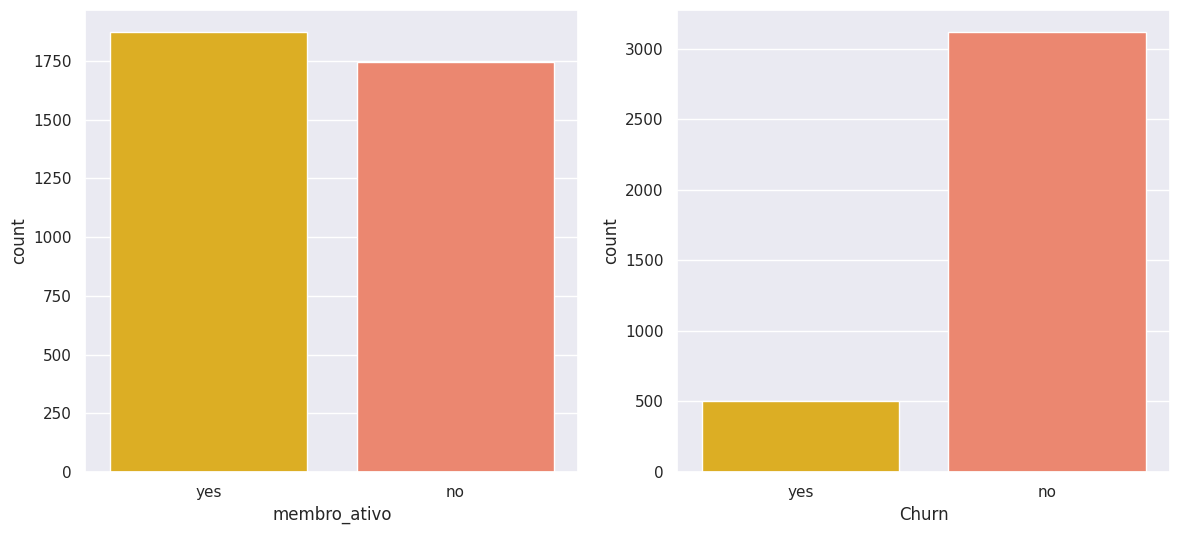

In [16]:
df_zero_balance = df2[['saldo', 'tempo_permanencia', 'membro_ativo', 'Churn']].loc[df2['saldo'] == 0]

plt.subplot(1, 2, 1)
sns.countplot(x= df_zero_balance['membro_ativo']);

plt.subplot(1, 2, 2)
sns.countplot(x= df_zero_balance['Churn']);

In [17]:
df_aux = df_zero_balance[['saldo', 'tempo_permanencia']].groupby('tempo_permanencia').count()
df_aux2 = df_zero_balance[['saldo', 'tempo_permanencia']].groupby('tempo_permanencia').count() / df_zero_balance.shape[0]

pd.concat([df_aux, df_aux2], axis= 1, keys= ['saldo_abs', 'saldo_perc'])

,saldo_abs,saldo_perc
,saldo,saldo
tempo_permanencia,,
0,137,0.037877
1,349,0.096489
2,382,0.105612
3,352,0.097318
4,369,0.102018
5,374,0.103401
6,367,0.101465
7,386,0.106718


In [18]:
mean = round(df_zero_balance['tempo_permanencia'].mean(), 2)
print(f'A média do tempo de permanência para contas com saldo zerado é de {mean}')

A média do tempo de permanência para contas com saldo zerado é de 5.07


### *tempo_permanencia*

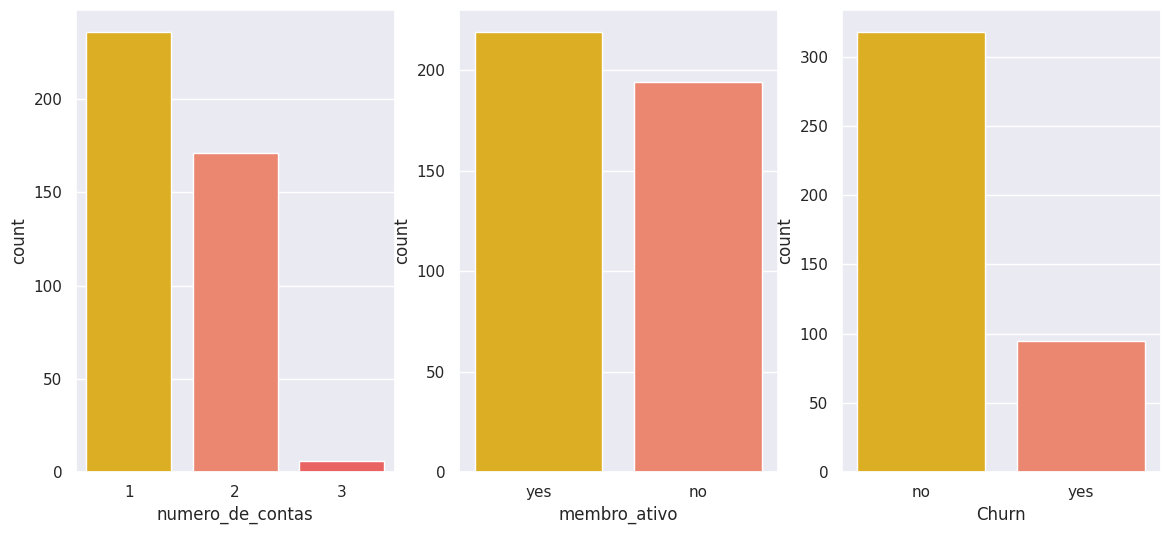

In [19]:
df_zero_tenure = df2[['tempo_permanencia', 'numero_de_contas', 'membro_ativo', 'Churn']].loc[df2['tempo_permanencia'] == 0]

plt.subplot(1, 3, 1)
sns.countplot(x= df_zero_tenure['numero_de_contas']);

plt.subplot(1, 3, 2)
sns.countplot(x= df_zero_tenure['membro_ativo']);

plt.subplot(1, 3, 3)
sns.countplot(x= df_zero_tenure['Churn']);

### 'saldo' zerados:

    1. praticamente se divide igualmentente em membros ativos e não ativos;
    2. de 3617 saldos zerados, apenas 500 são de clientes que irão dar churn
    3. a média do tempo de permanência para contas com saldo zerado é de 5.07
    4. a menor frequência de saldos zerados, são para clientes que adquiriram o em menos de 1 ano.

Logo é possível supor:

    - saldos zerados não siginificam que são de contas pré criadas (obs. 4)
    - saldos zerados não possuem relação clara com membros ativos e inativos.
    
Suposição principal: Ignorar os questionamentos levantados na V1. Saldos zerados, representam de fato, contas sem capital disponível.
    
### 'tempo_de_permanencia' zerados:

Suposição principal: Como 'tempo_de_permanencia' zerados representam menos de 5% dos dados, vou ignorar também os questionamentos levantados na V1 e considerar que são cliente que adquiriram em menos de 1 ano.

## Note:
Solução do problema de negócio:
    
1. Qual é a atual taxa de Churn do Top Bank?

        S: Análise Univariada da variável resposta 'Churn' > plotar gráfico de barras de churns e não-churns e printar porcentagem da relação das classes (concluído)


2. Como a taxa de churn varia mensalmente?

        S: Pela descrição dos dados já é possível avaliar que não existe uma variável temporal no conjunto de dados, mas a variável 'membro_ativo' está associada com a atividade durante 12 meses, logo é possível buscar uma correlação para tentar responder a segunda questão de negócio. (pendente)
        
3. Qual é o desempenho do modelo na classificação de clientes como churns?

        S: Criar modelo de classificação com as variáveis selecionadas por relevância (Análise Bivariada) e pelo Boruta. (em progresso)
        
4. Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?

        S: Com o modelo criado, é possível estimar o retorno esperado, criando casos de deduções sobre os salários de cada cliente. (pendente)

# Feature Engineering I (Creation of New Variables)

In [20]:
df3 = df2.copy()

In [21]:
#Escala FICO
df3['escala_fico'] = df3['score_credito'].apply(lambda x: 'too bad' if x < 580 else 'bad' if x < 670 else 'good' if x < 740 else 'very good' if x < 800 else 'excellent')

In [22]:
#Ticket Médio (é o valor mensal da assinatura de conta) *20 US$ Mensais:
taxa_conta = 20
df3['ticket_medio'] = df3['numero_de_contas'].apply(lambda x: taxa_conta * x)

#LTV Médio (o quanto de receita o cliente representa para o negócio durante um determinado período de tempo)
	#fórmula: ticket médio X tempo de permanencia (anos) X 12 meses
df3['LTV_medio'] = df3.apply(lambda x: round(x['ticket_medio'] * x['tempo_permanencia'] * 12 , 2), axis= 1)

In [23]:
#Média salarial por idade
mean_salary_for_age = df3[['salario_estimado', 'idade']].groupby('idade').mean().reset_index()
mean_salary_for_age.columns = ['idade', 'salario_por_idade']

mean_salary_for_age['salario_por_idade'] = mean_salary_for_age['salario_por_idade'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_salary_for_age, on= 'idade', how= 'left')

In [24]:
#Média de saldo por idade
mean_balance_for_age = df3[['saldo', 'idade']].groupby('idade').mean().reset_index()
mean_balance_for_age.columns = ['idade', 'saldo_por_idade']

mean_balance_for_age['saldo_por_idade'] = mean_balance_for_age['saldo_por_idade'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_balance_for_age, on= 'idade', how= 'left')

In [25]:
#Mediana de tempo de permanencia por idade
median_tenure_for_age = df3[['tempo_permanencia', 'idade']].groupby('idade').median().reset_index()
median_tenure_for_age.columns = ['idade', 'tempo_permanencia_por_idade']

#merge
df3 = pd.merge(df3, median_tenure_for_age, on= 'idade', how= 'left')

In [26]:
#Média de LTV por idade
mean_ltv_for_age = df3[['LTV_medio', 'idade']].groupby('idade').mean().reset_index()
mean_ltv_for_age.columns = ['idade', 'LTV_por_idade']

mean_ltv_for_age['LTV_por_idade'] = mean_ltv_for_age['LTV_por_idade'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_ltv_for_age, on= 'idade', how= 'left')

In [27]:
#Média salarial por tempo permanencia
mean_salary_for_tenure = df3[['salario_estimado', 'tempo_permanencia']].groupby('tempo_permanencia').mean().reset_index()
mean_salary_for_tenure.columns = ['tempo_permanencia', 'salario_por_tempo_permanencia']

mean_salary_for_tenure['salario_por_tempo_permanencia'] = mean_salary_for_tenure['salario_por_tempo_permanencia'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_salary_for_tenure, on= 'tempo_permanencia', how= 'left')

In [28]:
#Média de saldo por tempo permanencia
mean_balance_for_tenure = df3[['saldo', 'tempo_permanencia']].groupby('tempo_permanencia').mean().reset_index()
mean_balance_for_tenure.columns = ['tempo_permanencia', 'saldo_por_tempo_permanencia']

mean_balance_for_tenure['saldo_por_tempo_permanencia'] = mean_balance_for_tenure['saldo_por_tempo_permanencia'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_balance_for_tenure, on= 'tempo_permanencia', how= 'left')

In [29]:
#Mediana de idade por tempo permanencia
median_age_for_tenure = df3[['idade', 'tempo_permanencia']].groupby('tempo_permanencia').median().reset_index()
median_age_for_tenure.columns = ['tempo_permanencia', 'idade_por_tempo_permanencia']

#merge
df3 = pd.merge(df3, median_age_for_tenure, on= 'tempo_permanencia', how= 'left')

In [30]:
#Média de LTV por tempo permanencia
mean_ltv_for_tenure = df3[['LTV_medio', 'tempo_permanencia']].groupby('tempo_permanencia').mean().reset_index()
mean_ltv_for_tenure.columns = ['tempo_permanencia', 'LTV_por_tempo_permanencia']

mean_ltv_for_tenure['LTV_por_tempo_permanencia'] = mean_ltv_for_tenure['LTV_por_tempo_permanencia'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_ltv_for_tenure, on= 'tempo_permanencia', how= 'left')

In [31]:
#Média salarial por numero de contas
mean_salary_for_num_of_products = df3[['salario_estimado', 'numero_de_contas']].groupby('numero_de_contas').mean().reset_index()
mean_salary_for_num_of_products.columns = ['numero_de_contas', 'salario_por_numero_de_contas']

mean_salary_for_num_of_products['salario_por_numero_de_contas'] = mean_salary_for_num_of_products['salario_por_numero_de_contas'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_salary_for_num_of_products, on= 'numero_de_contas', how= 'left')

In [32]:
#Média de saldo por numero de contas
mean_balance_for_num_of_products = df3[['saldo', 'numero_de_contas']].groupby('numero_de_contas').mean().reset_index()
mean_balance_for_num_of_products.columns = ['numero_de_contas', 'saldo_por_numero_de_contas']

mean_balance_for_num_of_products['saldo_por_numero_de_contas'] = mean_balance_for_num_of_products['saldo_por_numero_de_contas'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_balance_for_num_of_products, on= 'numero_de_contas', how= 'left')

In [33]:
#Mediana de tempo permanencia por numero de contas
median_tenure_for_num_of_products = df3[['tempo_permanencia', 'numero_de_contas']].groupby('numero_de_contas').median().reset_index()
median_tenure_for_num_of_products.columns = ['numero_de_contas', 'tempo_permanencia_por_numero_de_contas']

#merge
df3 = pd.merge(df3, median_tenure_for_num_of_products, on= 'numero_de_contas', how= 'left')

In [34]:
#Mediana de idade por numero de contas
median_age_for_num_of_products = df3[['idade', 'numero_de_contas']].groupby('numero_de_contas').median().reset_index()
median_age_for_num_of_products.columns = ['numero_de_contas', 'idade_por_numero_de_contas']

#merge
df3 = pd.merge(df3, median_age_for_num_of_products, on= 'numero_de_contas', how= 'left')

In [35]:
#Média de LTV por numero de contas
mean_ltv_for_num_of_products = df3[['LTV_medio', 'numero_de_contas']].groupby('numero_de_contas').mean().reset_index()
mean_ltv_for_num_of_products.columns = ['numero_de_contas', 'LTV_por_numero_de_contas']

mean_ltv_for_num_of_products['LTV_por_numero_de_contas'] = mean_ltv_for_num_of_products['LTV_por_numero_de_contas'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_ltv_for_num_of_products, on= 'numero_de_contas', how= 'left')

In [36]:
#Média salarial por escala FICO
mean_salary_for_fico_scale = df3[['salario_estimado', 'escala_fico']].groupby('escala_fico').mean().reset_index()
mean_salary_for_fico_scale.columns = ['escala_fico', 'salario_por_escala_fico']

mean_salary_for_fico_scale['salario_por_escala_fico'] = mean_salary_for_fico_scale['salario_por_escala_fico'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_salary_for_fico_scale, on= 'escala_fico', how= 'left')

In [37]:
#Média de saldo por escala FICO
mean_balance_for_fico_scale = df3[['saldo', 'escala_fico']].groupby('escala_fico').mean().reset_index()
mean_balance_for_fico_scale.columns = ['escala_fico', 'saldo_por_escala_fico']

mean_balance_for_fico_scale['saldo_por_escala_fico'] = mean_balance_for_fico_scale['saldo_por_escala_fico'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_balance_for_fico_scale, on= 'escala_fico', how= 'left')

In [38]:
#Mediana de idade por escala FICO
median_tenure_for_fico_scale = df3[['tempo_permanencia', 'escala_fico']].groupby('escala_fico').median().reset_index()
median_tenure_for_fico_scale.columns = ['escala_fico', 'tempo_permanencia_por_escala_fico']

#merge
df3 = pd.merge(df3, median_tenure_for_fico_scale, on= 'escala_fico', how= 'left')

In [39]:
#Mediana de idade por escala FICO
median_age_for_fico_scale = df3[['idade', 'escala_fico']].groupby('escala_fico').median().reset_index()
median_age_for_fico_scale.columns = ['escala_fico', 'idade_por_escala_fico']

#merge
df3 = pd.merge(df3, median_age_for_fico_scale, on= 'escala_fico', how= 'left')

In [40]:
#Média de LTV por escala FICO
mean_ltv_for_fico_scale = df3[['LTV_medio', 'escala_fico']].groupby('escala_fico').mean().reset_index()
mean_ltv_for_fico_scale.columns = ['escala_fico', 'LTV_por_escala_fico']

mean_ltv_for_fico_scale['LTV_por_escala_fico'] = mean_ltv_for_fico_scale['LTV_por_escala_fico'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_ltv_for_fico_scale, on= 'escala_fico', how= 'left')

In [41]:
#Média salarial por gênero
mean_salary_for_gender = df3[['salario_estimado', 'genero']].groupby('genero').mean().reset_index()
mean_salary_for_gender.columns = ['genero', 'salario_por_genero']

mean_salary_for_gender['salario_por_genero'] = mean_salary_for_gender['salario_por_genero'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_salary_for_gender, on= 'genero', how= 'left')

In [42]:
#Média de saldo por gênero
mean_balance_for_gender = df3[['saldo', 'genero']].groupby('genero').mean().reset_index()
mean_balance_for_gender.columns = ['genero', 'saldo_por_genero']

mean_balance_for_gender['saldo_por_genero'] = mean_balance_for_gender['saldo_por_genero'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_balance_for_gender, on= 'genero', how= 'left')

In [43]:
#Mediana de tempo permanencia por gênero
median_tenure_for_gender = df3[['tempo_permanencia', 'genero']].groupby('genero').median().reset_index()
median_tenure_for_gender.columns = ['genero', 'tempo_permanencia_por_genero']

#merge
df3 = pd.merge(df3, median_tenure_for_gender, on= 'genero', how= 'left')

In [44]:
#Mediana da idade por gênero
median_age_for_gender = df3[['idade', 'genero']].groupby('genero').median().reset_index()
median_age_for_gender.columns = ['genero', 'idade_por_genero']

#merge
df3 = pd.merge(df3, median_age_for_gender, on= 'genero', how= 'left')

In [45]:
#Média de LTV por gênero
mean_ltv_for_gender = df3[['LTV_medio', 'genero']].groupby('genero').mean().reset_index()
mean_ltv_for_gender.columns = ['genero', 'LTV_por_genero']

mean_ltv_for_gender['LTV_por_genero'] = mean_ltv_for_gender['LTV_por_genero'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_ltv_for_gender, on= 'genero', how= 'left')

In [46]:
#Média salarial por geografia
mean_salary_for_geography = df3[['salario_estimado', 'geografia']].groupby('geografia').mean().reset_index()
mean_salary_for_geography.columns = ['geografia', 'salario_por_geografia']

mean_salary_for_geography['salario_por_geografia'] = mean_salary_for_geography['salario_por_geografia'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_salary_for_geography, on= 'geografia', how= 'left')

In [47]:
#Média salarial por geografia
mean_balance_for_geography = df3[['saldo', 'geografia']].groupby('geografia').mean().reset_index()
mean_balance_for_geography.columns = ['geografia', 'saldo_por_geografia']

mean_balance_for_geography['saldo_por_geografia'] = mean_balance_for_geography['saldo_por_geografia'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_balance_for_geography, on= 'geografia', how= 'left')

In [48]:
#Mediana de tempo permanencia por geografia
median_tenure_for_geography = df3[['tempo_permanencia', 'geografia']].groupby('geografia').median().reset_index()
median_tenure_for_geography.columns = ['geografia', 'tempo_permanencia_por_geografia']

#merge
df3 = pd.merge(df3, median_tenure_for_geography, on= 'geografia', how= 'left')

In [49]:
#Mediana de idade por geografia
median_age_for_geography = df3[['idade', 'geografia']].groupby('geografia').median().reset_index()
median_age_for_geography.columns = ['geografia', 'idade_por_geografia']

#merge
df3 = pd.merge(df3, median_age_for_geography, on= 'geografia', how= 'left')

In [50]:
#Média de LTV por geografia
mean_ltv_for_geography = df3[['LTV_medio', 'geografia']].groupby('geografia').mean().reset_index()
mean_ltv_for_geography.columns = ['geografia', 'LTV_por_geografia']

mean_ltv_for_geography['LTV_por_geografia'] = mean_ltv_for_geography['LTV_por_geografia'].apply(lambda x: round(x, 3))

#merge
df3 = pd.merge(df3, mean_ltv_for_geography, on= 'geografia', how= 'left')

In [51]:
df3

,numero_linha,id_cliente,sobrenome,score_credito,geografia,genero,idade,tempo_permanencia,saldo,numero_de_contas,tem_cartao_credito,membro_ativo,salario_estimado,Churn,escala_fico,ticket_medio,LTV_medio,salario_por_idade,saldo_por_idade,tempo_permanencia_por_idade,LTV_por_idade,salario_por_tempo_permanencia,saldo_por_tempo_permanencia,idade_por_tempo_permanencia,LTV_por_tempo_permanencia,salario_por_numero_de_contas,saldo_por_numero_de_contas,tempo_permanencia_por_numero_de_contas,idade_por_numero_de_contas,LTV_por_numero_de_contas,salario_por_escala_fico,saldo_por_escala_fico,tempo_permanencia_por_escala_fico,idade_por_escala_fico,LTV_por_escala_fico,salario_por_genero,saldo_por_genero,tempo_permanencia_por_genero,idade_por_genero,LTV_por_genero,salario_por_geografia,saldo_por_geografia,tempo_permanencia_por_geografia,idade_por_geografia,LTV_por_geografia
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,yes,yes,101348.88,yes,bad,20,480,96681.211,76785.312,5.0,1896.075,98312.360,76839.626,37.0,763.053,99487.257,98551.871,5.0,38.0,1193.910,99406.522,76919.460,5.0,37.0,1883.182,100601.541,75659.369,5.0,38.0,1841.444,99899.181,62092.637,5.0,37.0,1847.100
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,no,yes,112542.58,no,bad,20,240,106768.127,75742.975,5.0,1872.787,100468.619,78555.384,38.0,357.565,99487.257,98551.871,5.0,38.0,1193.910,99406.522,76919.460,5.0,37.0,1883.182,100601.541,75659.369,5.0,38.0,1841.444,99440.572,61818.148,5.0,37.0,1865.353
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,yes,no,113931.57,yes,too bad,60,5760,96681.211,76785.312,5.0,1896.075,101072.103,77936.598,37.0,2924.020,104318.131,75458.328,5.0,42.0,3602.707,100715.360,75900.472,5.0,37.0,1816.257,100601.541,75659.369,5.0,38.0,1841.444,99899.181,62092.637,5.0,37.0,1847.100
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,no,no,93826.63,no,good,40,480,95225.690,74285.289,5.0,1914.326,100468.619,78555.384,38.0,357.565,100452.013,51879.146,5.0,36.0,2424.889,100523.541,74978.995,5.0,37.0,1816.507,100601.541,75659.369,5.0,38.0,1841.444,99899.181,62092.637,5.0,37.0,1847.100
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,yes,yes,79084.10,no,excellent,20,480,98148.691,81636.038,5.0,1850.505,98312.360,76839.626,37.0,763.053,99487.257,98551.871,5.0,38.0,1193.910,100338.736,76976.408,5.0,37.0,1815.573,100601.541,75659.369,5.0,38.0,1841.444,99440.572,61818.148,5.0,37.0,1865.353
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,yes,no,149756.71,yes,bad,40,3840,98190.766,78244.492,5.0,1888.249,101072.103,77936.598,37.0,2924.020,100452.013,51879.146,5.0,36.0,2424.889,99406.522,76919.460,5.0,37.0,1883.182,99664.577,77173.975,5.0,37.0,1850.467,99440.572,61818.148,5.0,37.0,1865.353
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,yes,yes,10062.80,no,excellent,40,3360,95349.181,84924.807,5.0,1903.881,101257.240,75551.634,37.0,2570.661,100452.013,51879.146,5.0,36.0,2424.889,100338.736,76976.408,5.0,37.0,1815.573,99664.577,77173.975,5.0,37.0,1850.467,99899.181,62092.637,5.0,37.0,1847.100
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,yes,no,119346.88,yes,too bad,80,3840,101159.596,68990.370,5.0,1935.172,99867.778,74059.394,37.0,1456.016,104763.723,93733.135,5.0,45.0,5088.000,100715.360,75900.472,5.0,37.0,1816.257,100601.541,75659.369,5.0,38.0,1841.444,101113.435,119730.116,5.0,38.0,1826.162
8,9,15792365,He,501,France,Male,44,4,142051.07,2,no,yes,74940.50,no,too bad,40,1920,98190.766,78244.492,5.0,1888.249,99867.778,74059.394,37.0,1456.016,100452.013,51879.146,5.0,36.0,2424.889,100715.360,75900.472,5.0,37.0,1816.257,99664.577,77173.975,5.0,37.0,1850.467,99899.181,62092.637,5.0,37.0,1847.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Note:
Próxima versão:
	
- Criar função para criação de features mais otimizada.

# Exploratory Data Analysis

In [52]:
df4 = df3.copy()

## Defining Variables for Analysis

In [53]:
#Response Variable
response_variable = df4['Churn']

#Numeric Variables
numeric_attributes = df4.select_dtypes(include= ['int64', 'float64'])

#Categorical Variables
categorical_attributes = df4.select_dtypes(exclude= ['int64', 'float64'])

## Univariate Analysis

### Response Variable

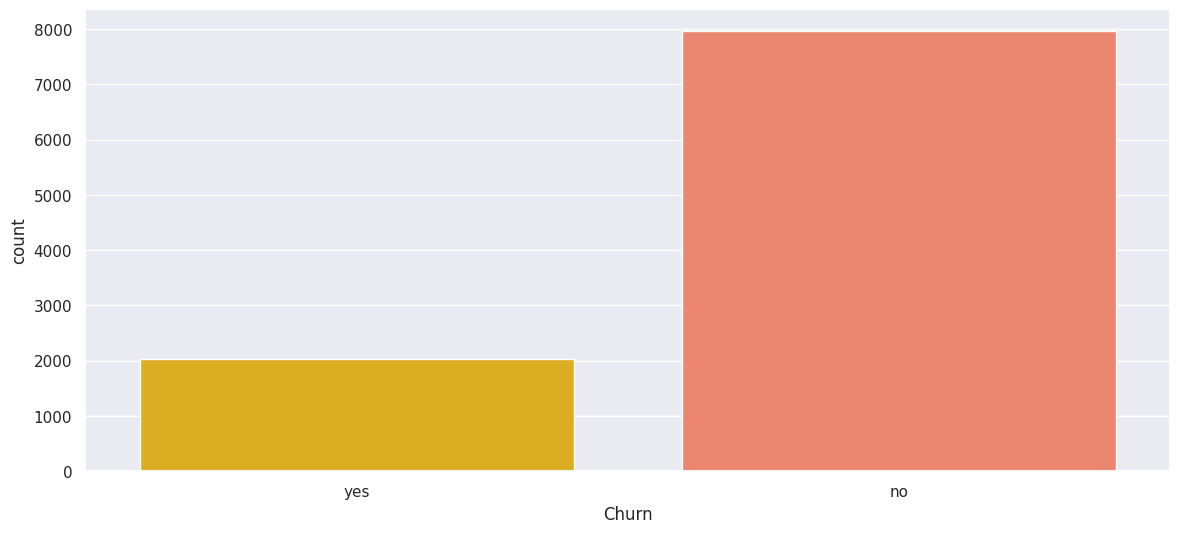

In [54]:
sns.countplot(x= response_variable);

In [55]:
percentage_no_churn = df4[['id_cliente', 'Churn']].loc[df4['Churn'] == 'no'].shape[0] / df4.shape[0] * 100
percentage_yes_churn = df4[['id_cliente', 'Churn']].loc[df4['Churn'] == 'yes'].shape[0] / df4.shape[0] * 100
print(f'Clientes que irão dar Churn correspondem a {percentage_yes_churn:.2f}%  da base de dados e clientes que não irão dar Churn correspondem a {percentage_no_churn:.2f}% da base de dados.')

Clientes que irão dar Churn correspondem a 20.37%  da base de dados e clientes que não irão dar Churn correspondem a 79.63% da base de dados.


- É evidente que a variável resposta possui classes desbalanceadas

### Numeric Variables

In [56]:
pd.options.display.max_rows = numeric_descriptive_statistical(numeric_attributes).shape[0]

In [57]:
numeric_descriptive_statistical(numeric_attributes)

,Variáveis,Mínimo,Máximo,Range,Valores Únicos,Média,Mediana,Desv. Padrão,Assimetria,Curtose
0,numero_linha,1.000000e+00,1.000000e+04,9999.000,10000.0,5.000500e+03,5.000500e+03,2886.751332,0.000000,-1.200000
1,id_cliente,1.556570e+07,1.581569e+07,249989.000,10000.0,1.569094e+07,1.569074e+07,71932.589224,0.001149,-1.196113
2,score_credito,3.500000e+02,8.500000e+02,500.000,460.0,6.505288e+02,6.520000e+02,96.648466,-0.071607,-0.425726
3,idade,1.800000e+01,9.200000e+01,74.000,70.0,3.892180e+01,3.700000e+01,10.487282,1.011320,1.395347
4,tempo_permanencia,0.000000e+00,1.000000e+01,10.000,11.0,5.012800e+00,5.000000e+00,2.892030,0.010991,-1.165225
5,saldo,0.000000e+00,2.508981e+05,250898.090,6382.0,7.648589e+04,9.719854e+04,62394.285254,-0.141109,-1.489412
6,numero_de_contas,1.000000e+00,4.000000e+00,3.000,4.0,1.530200e+00,1.000000e+00,0.581625,0.745568,0.582981
7,salario_estimado,1.158000e+01,1.999925e+05,199980.900,9999.0,1.000902e+05,1.001939e+05,57507.617221,0.002085,-1.181518
8,ticket_medio,2.000000e+01,8.000000e+01,60.000,4.0,3.060400e+01,2.000000e+01,11.632505,0.745568,0.582981
9,LTV_medio,0.000000e+00,9.600000e+03,9600.000,25.0,1.846368e+03,1.680000e+03,1339.575727,1.014525,1.272033


In [58]:
pd.options.display.max_rows = False

- **Muitos valores distintos**: *score_credito, idade, saldo, salário estimado, LTV_medio*.
- **Poucos valores distintos**: *tempo_permanencia, numero_de_contas, ticket_medio*;

- **Valores sem valores distintos**: *tempo_permanencia_por_numero_de_contas, tempo_permanencia_por_escala_fico, idade_por_escala_fico, tempo_permanencia_por_genero e tempo_permanencia_por_geografia* >>> <code style="color: red">features bivariadas que serão excluidas por não trazerem informações, devido a ausência de variância em seus dados</code>

**OBS**.: features bivariadas serão ignoradas na análise univariada dos dados.

#### *score_credito*

Mínimo:350.00
Média:650.53
Mediana:652.00
Moda:850.00
Máximo:850.00
Primeiro Quartil:584.00
Terceiro Quartil:718.00


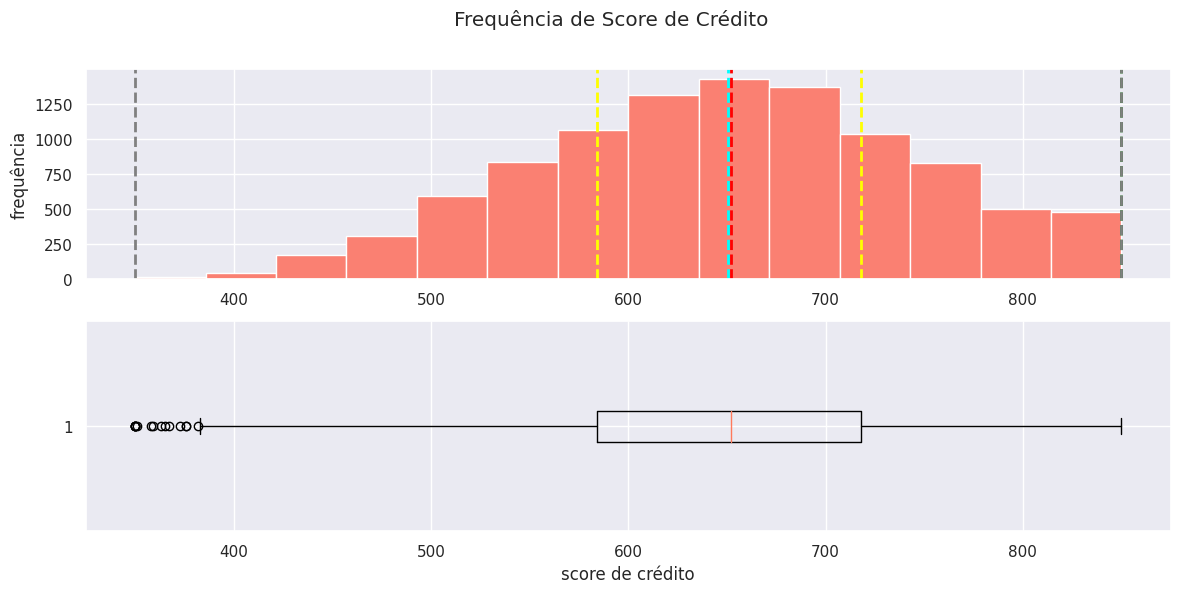

In [59]:
column = numeric_attributes['score_credito']
bins = n_bins(column)
title = "Frequência de Score de Crédito"
ylabel = "frequência"
xlabel = "score de crédito"
show_univariate_numeric_distribution(column, bins= bins, title= title, ylabel= ylabel, xlabel= xlabel)

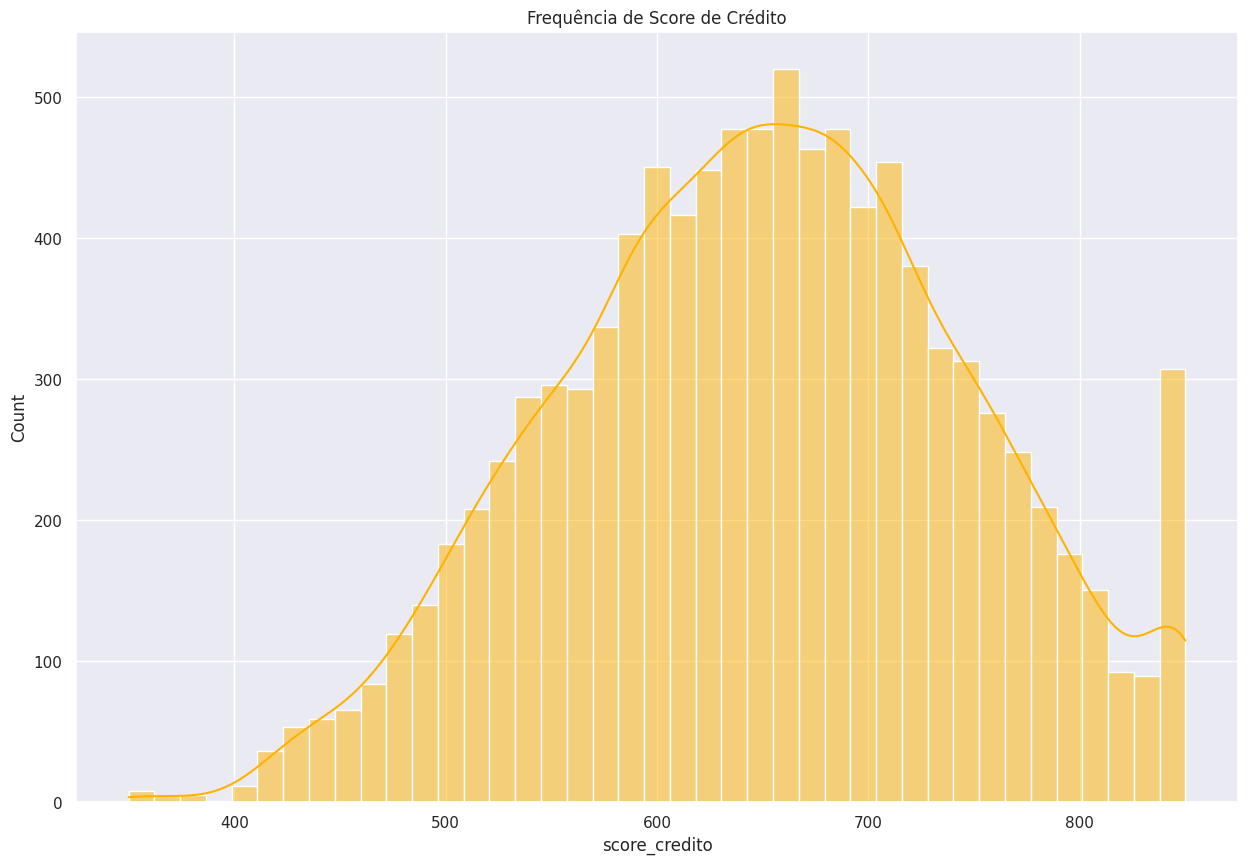

In [60]:
plt.figure(figsize=(15,10))
sns.histplot(numeric_attributes['score_credito'], kde= True, color= '#ffb300').set_title('Frequência de Score de Crédito');

In [61]:
#Note: 
	# segundo os intervalos de scores de crédito da FICO:
    	# 300 - 580: muito baixo;
        # 580 - 670: baixo;
        # 670 - 740: bom;
        # 740 - 800: muito bom;
        # 800 - 850: excelente;
    # não existe uma distância considerável entre os valores da média e mediana, logo a distância interquatilica Q25 - Medina - Q75 (onde compreende a metade dos dados)
# são praticamente simétricas, fazendo com que a distribuiçaõ dos dados de 'score_credito' se aproxime de uma gaussiana (distribuição normal).
    # outliers para scores que se aproximam de 350, logo o banco possui poucos clientes se aproximando do mínimo score_permitido pelo banco (350)  
    # a moda é igual ao valor máximo, o que pode evidênciar que o banco possui um grupo seleto de cliente que são bons pagadores. (vale criação de caso para esse grupo)
    # hipótese: 'clientes que são bons pagadores, possuem o salário mais alto?' ou 'clentes que possuem salários altos, são bons pagadores?'

#### *idade*

Mínimo:18.00
Média:38.92
Mediana:37.00
Moda:37.00
Máximo:92.00
Primeiro Quartil:32.00
Terceiro Quartil:44.00


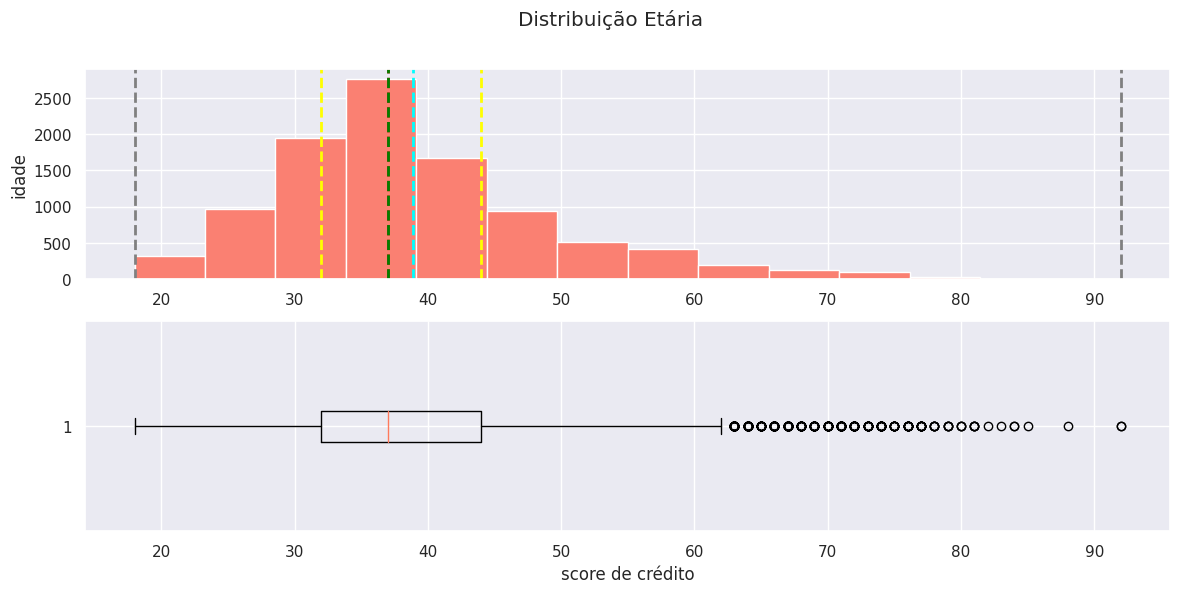

In [62]:
column = numeric_attributes['idade']
bins = n_bins(column)
title = "Distribuição Etária"
ylabel = "idade"
show_univariate_numeric_distribution(column, bins= bins, title= title, ylabel= ylabel, xlabel= xlabel)

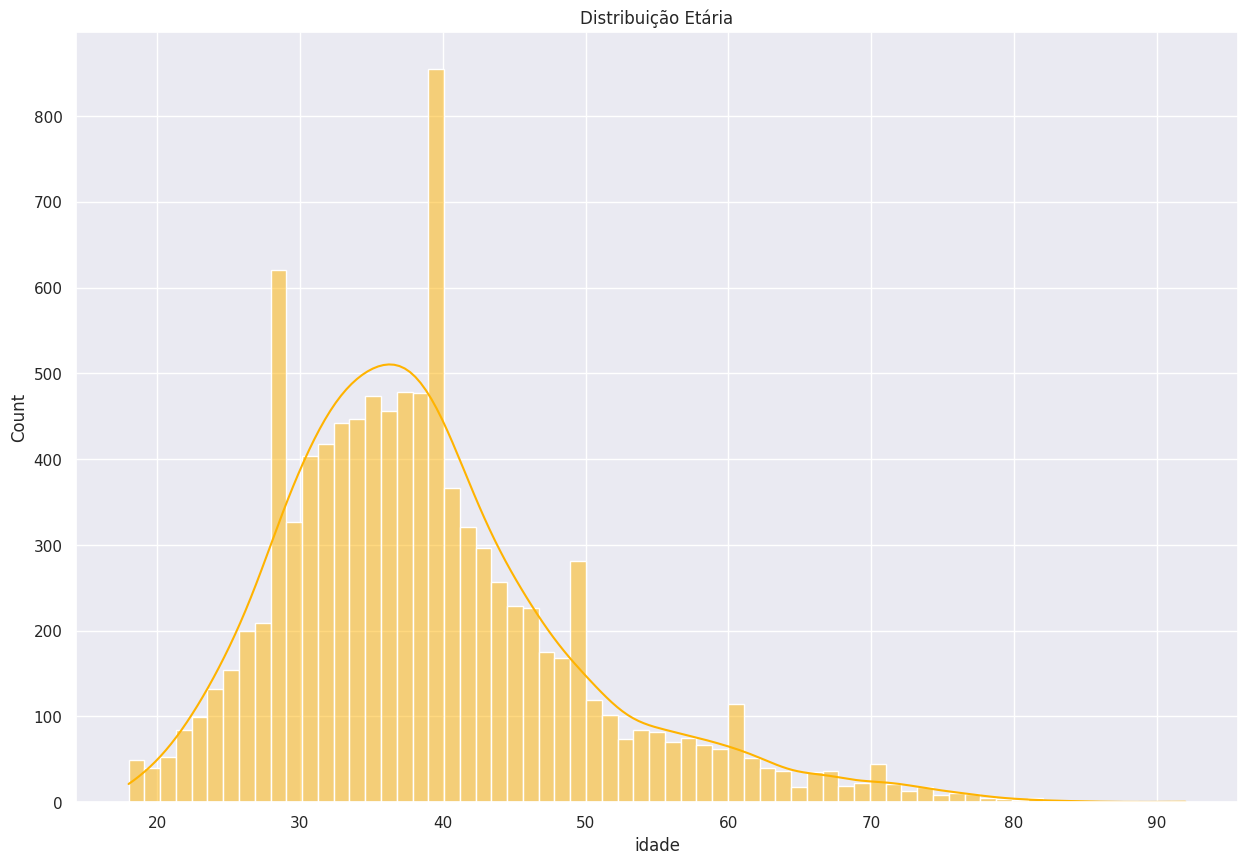

In [63]:
plt.figure(figsize=(15,10))
sns.histplot(numeric_attributes['idade'], kde= True, color= '#ffb300').set_title('Distribuição Etária');

#### *saldo*

Mínimo:0.00
Média:76485.89
Mediana:97198.54
Moda:0.00
Máximo:250898.09
Primeiro Quartil:0.00
Terceiro Quartil:127644.24


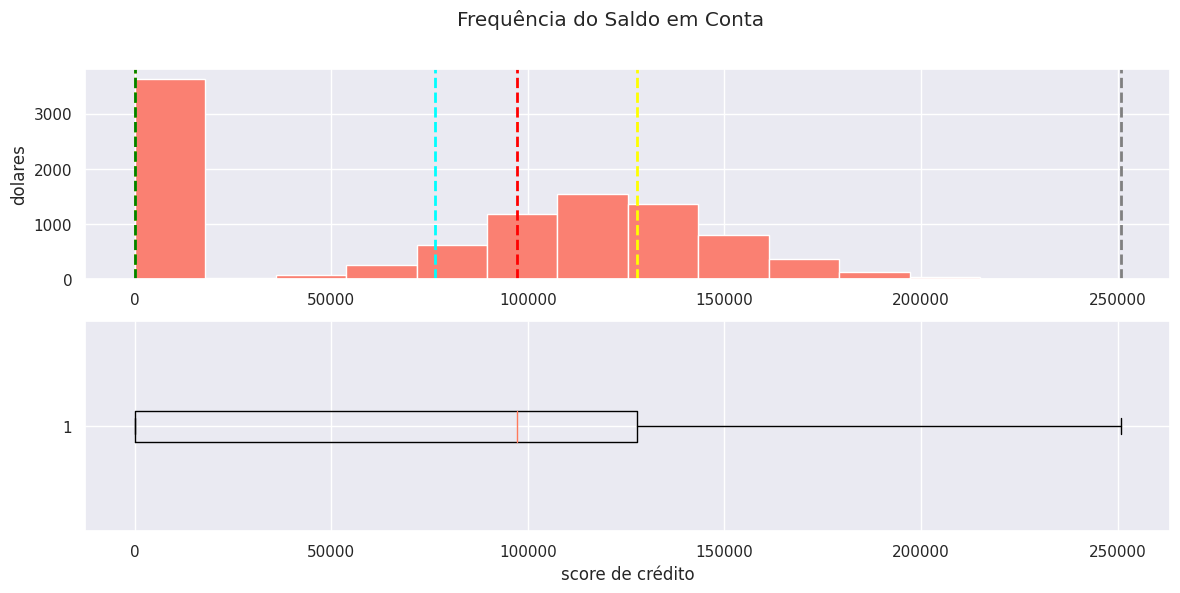

In [64]:
column = numeric_attributes['saldo']
bins = n_bins(column)
title = "Frequência do Saldo em Conta"
ylabel = "dolares"
show_univariate_numeric_distribution(column, bins= bins, title= title, ylabel= ylabel, xlabel= xlabel)

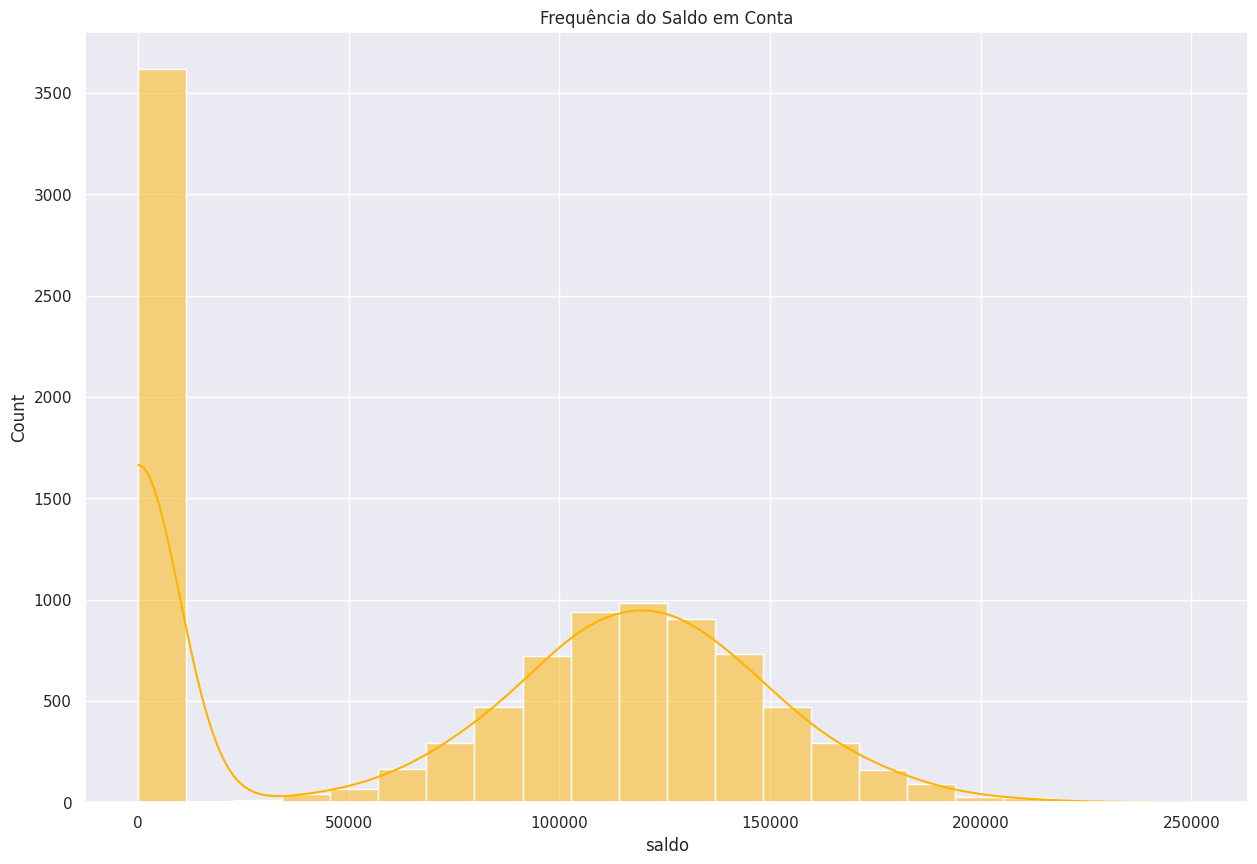

In [65]:
plt.figure(figsize=(15,10))
sns.histplot(numeric_attributes['saldo'], kde= True, color= '#ffb300').set_title('Frequência do Saldo em Conta');

#### *salario_estimado*

Mínimo:11.58
Média:100090.24
Mediana:100193.91
Moda:24924.92
Máximo:199992.48
Primeiro Quartil:51002.11
Terceiro Quartil:149388.25


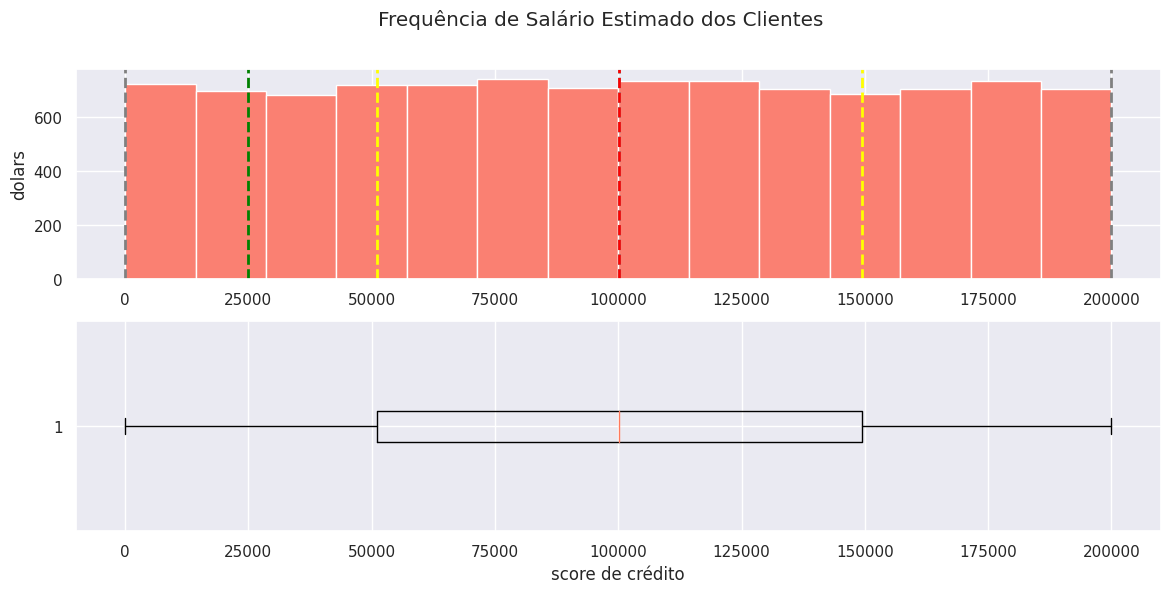

In [66]:
column = numeric_attributes['salario_estimado']
bins = n_bins(column)
title = "Frequência de Salário Estimado dos Clientes"
ylabel = "dolars"
show_univariate_numeric_distribution(column, bins= bins, title= title, ylabel= ylabel, xlabel= xlabel)

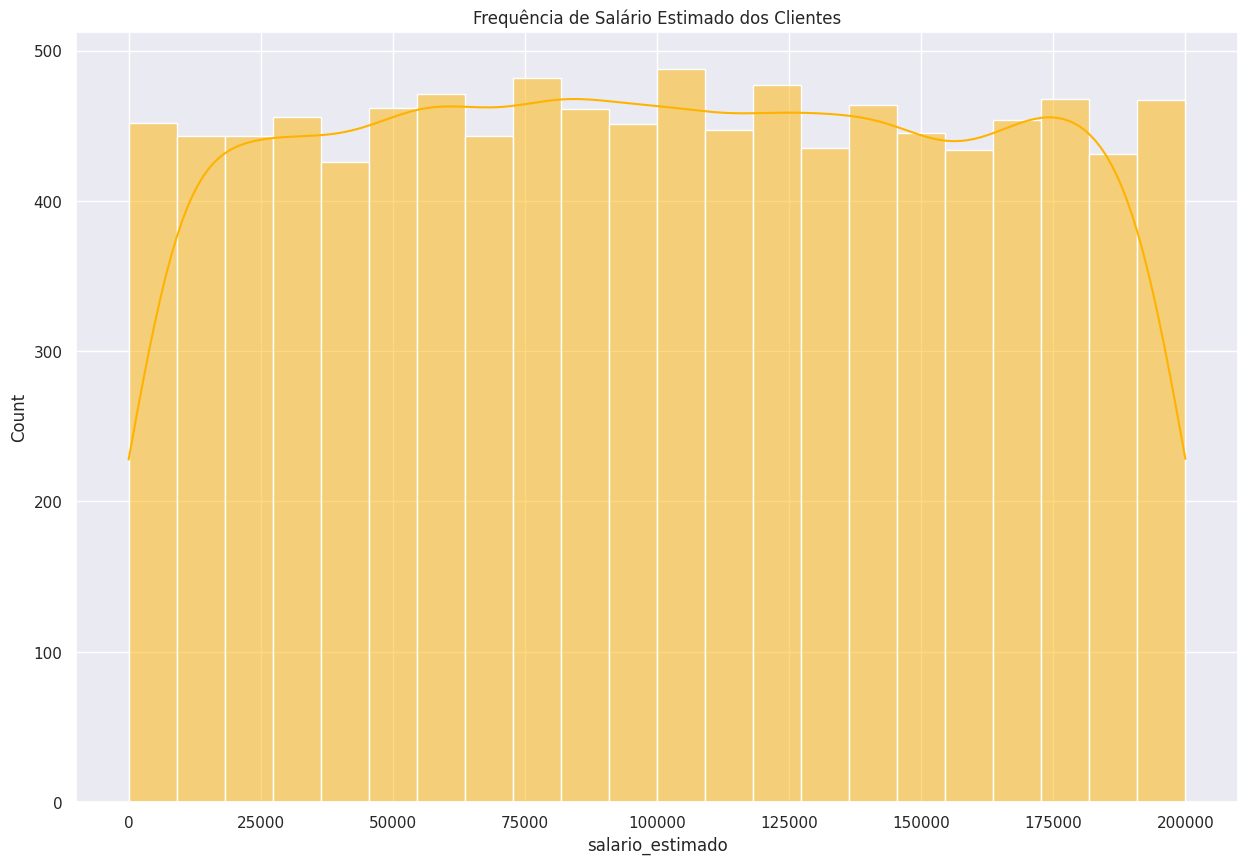

In [67]:
plt.figure(figsize=(15,10))
sns.histplot(numeric_attributes['salario_estimado'], kde= True, color= '#ffb300').set_title('Frequência de Salário Estimado dos Clientes');

#### *LTV_medio*

Mínimo:0.00
Média:1846.37
Mediana:1680.00
Moda:960.00
Máximo:9600.00
Primeiro Quartil:960.00
Terceiro Quartil:2400.00


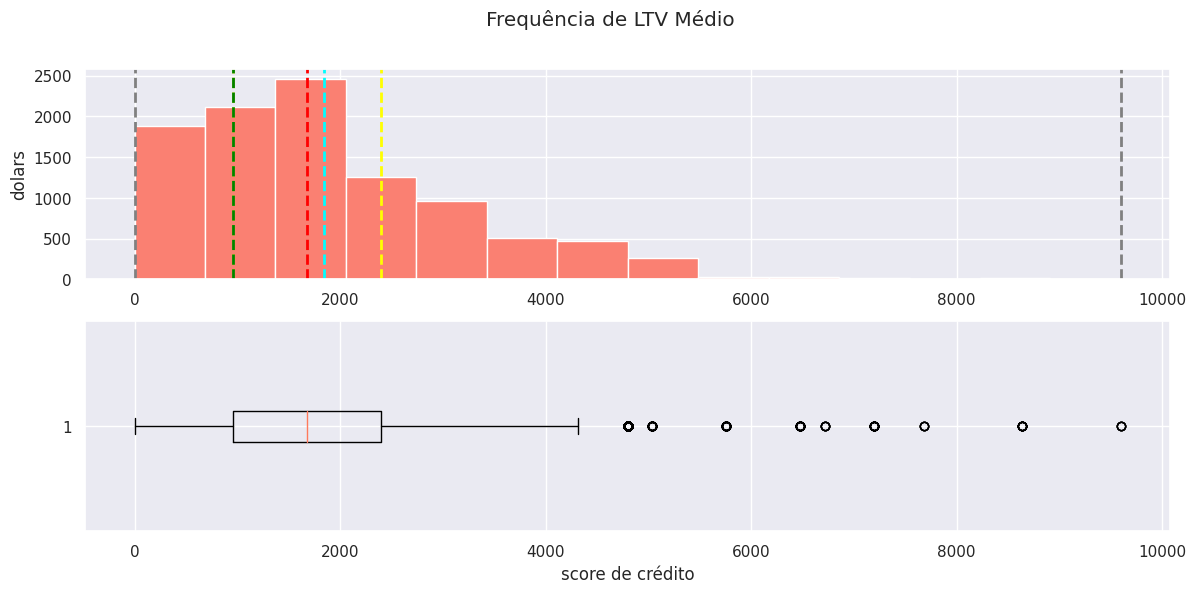

In [68]:
column = numeric_attributes['LTV_medio']
bins = n_bins(column)
title = "Frequência de LTV Médio"
ylabel = "dolars"
show_univariate_numeric_distribution(column, bins= bins, title= title, ylabel= ylabel, xlabel= xlabel)

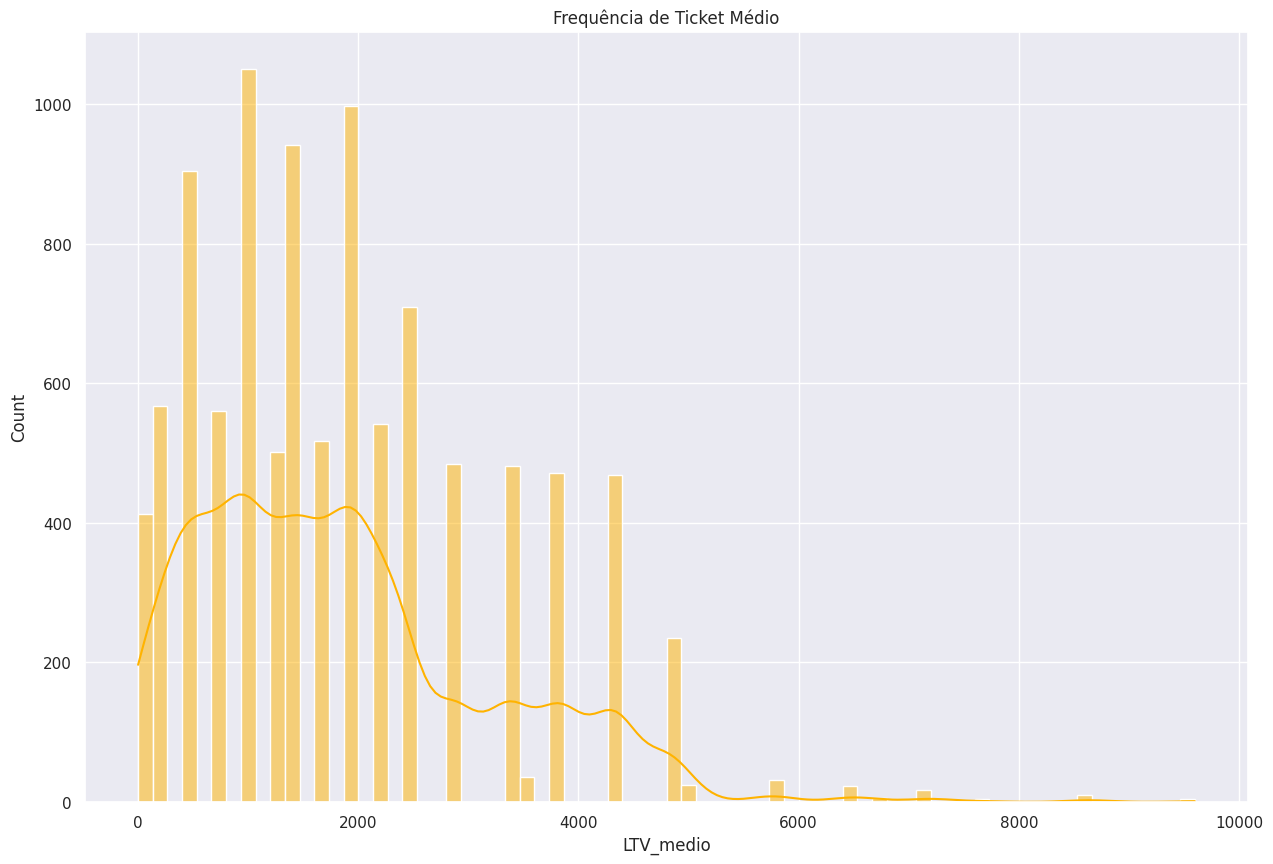

In [69]:
plt.figure(figsize=(15,10))
sns.histplot(numeric_attributes['LTV_medio'], kde= True, color= '#ffb300').set_title("Frequência de Ticket Médio");

#### *tempo_permanencia*

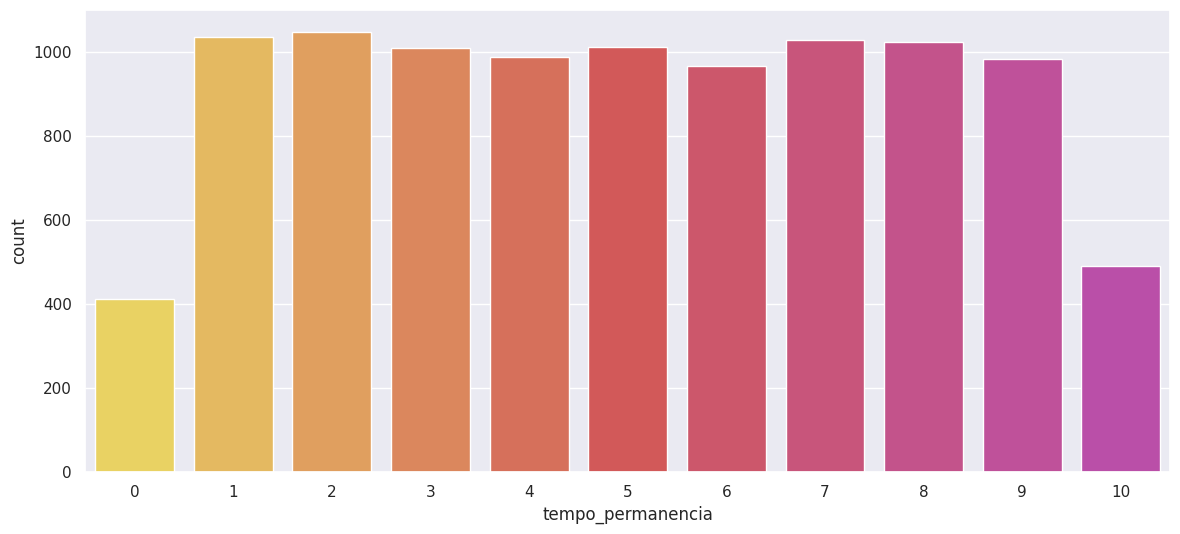

In [71]:
sns.countplot(x= df4['tempo_permanencia'], palette= sequencial_palette);

In [72]:
pd.DataFrame({'absoluto': df4['tempo_permanencia'].value_counts(), 'percentual (%)': df4['tempo_permanencia'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
2,1048,10.48
1,1035,10.35
7,1028,10.28
8,1025,10.25
5,1012,10.12
3,1009,10.09
4,989,9.89
9,984,9.84
6,967,9.67
10,490,4.90


#### *numero_de_contas*

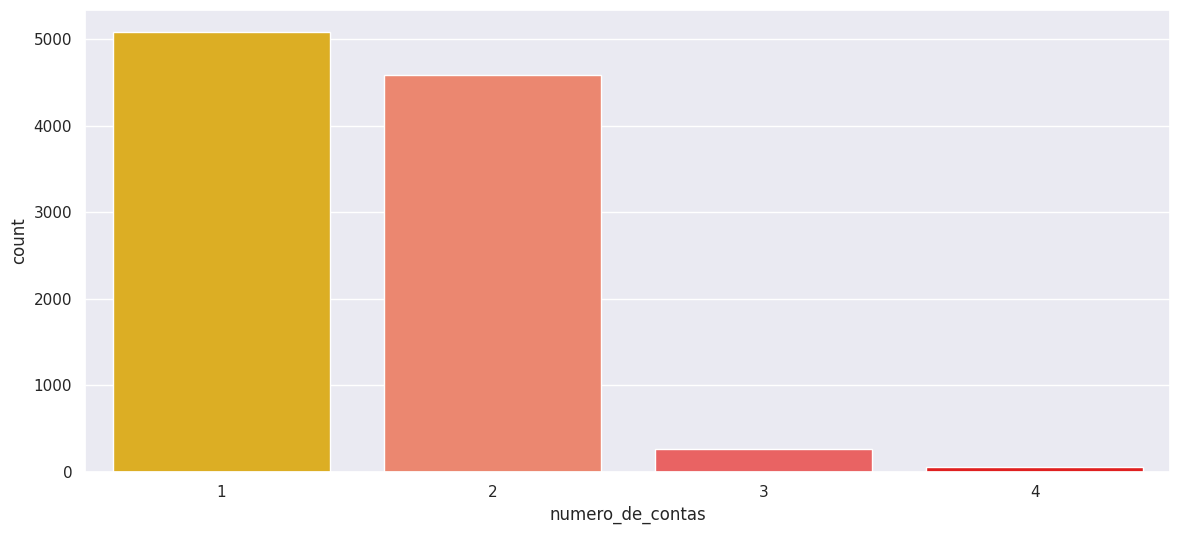

In [73]:
sns.countplot(x= df4['numero_de_contas']);

In [74]:
pd.DataFrame({'absoluto': df4['numero_de_contas'].value_counts(), 'percentual (%)': df4['numero_de_contas'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
1,5084,50.84
2,4590,45.90
3,266,2.66
4,60,0.60


#### *ticket_medio*

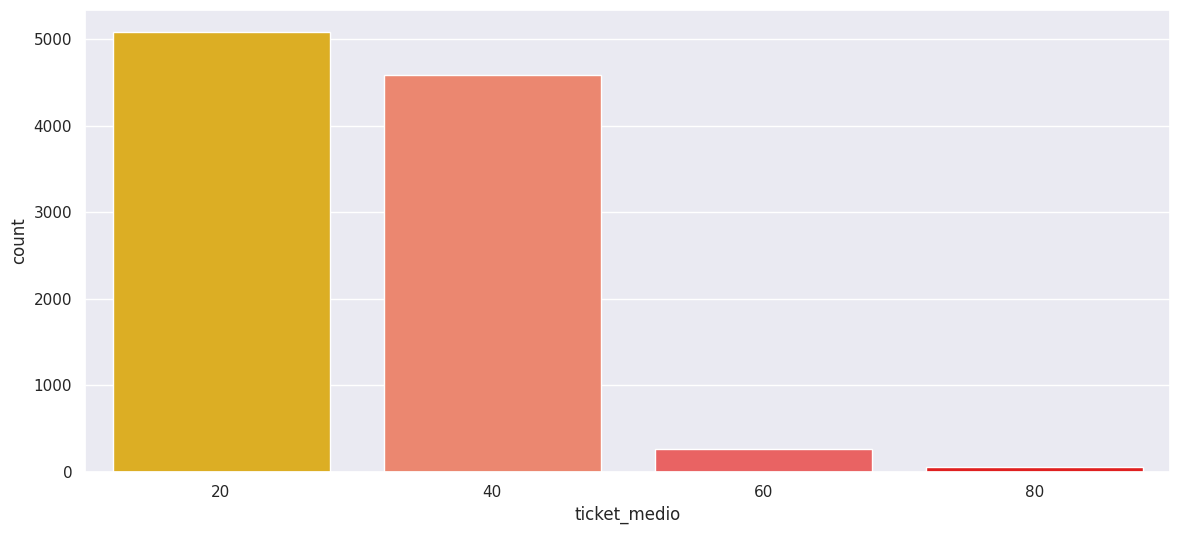

In [75]:
sns.countplot(x= numeric_attributes['ticket_medio']);

In [88]:
pd.DataFrame({'absoluto': df4['ticket_medio'].value_counts(), 'percentual (%)': df4['ticket_medio'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
20,5084,50.84
40,4590,45.90
60,266,2.66
80,60,0.60


### Categorical Variables

In [76]:
categorical_attributes.apply(lambda x: x.unique().shape[0])

sobrenome             2932
geografia                3
genero                   2
tem_cartao_credito       2
membro_ativo             2
Churn                    2
escala_fico              5
dtype: int64

#### *geografia*

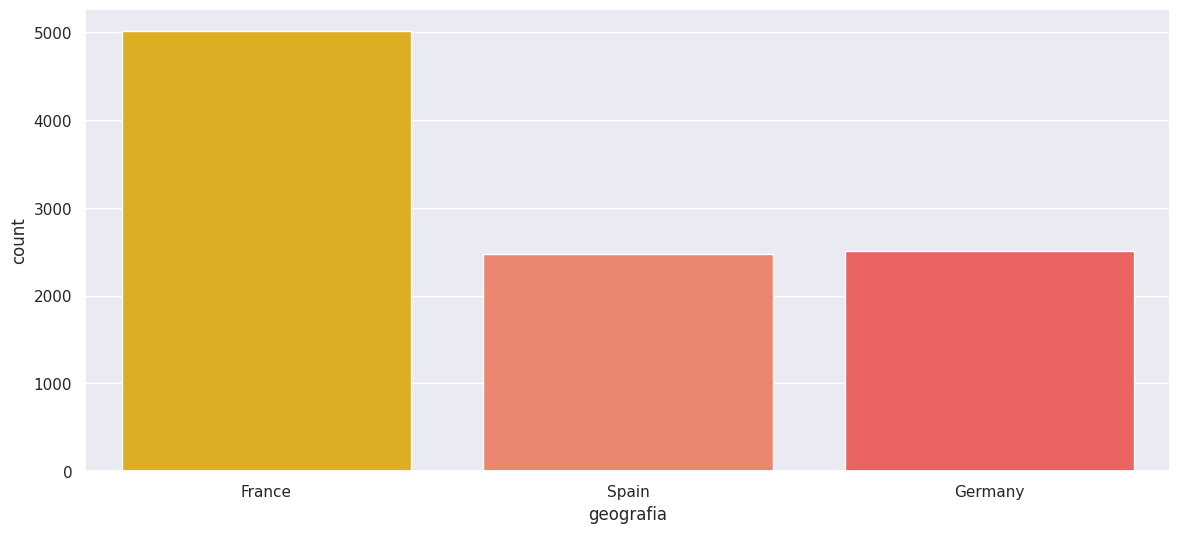

In [77]:
sns.countplot(x= df4['geografia'], palette= categorical_palette);

In [78]:
pd.DataFrame({'absoluto': df4['geografia'].value_counts(), 'percentual (%)': df4['geografia'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
France,5014,50.14
Germany,2509,25.09
Spain,2477,24.77


#### *genero*

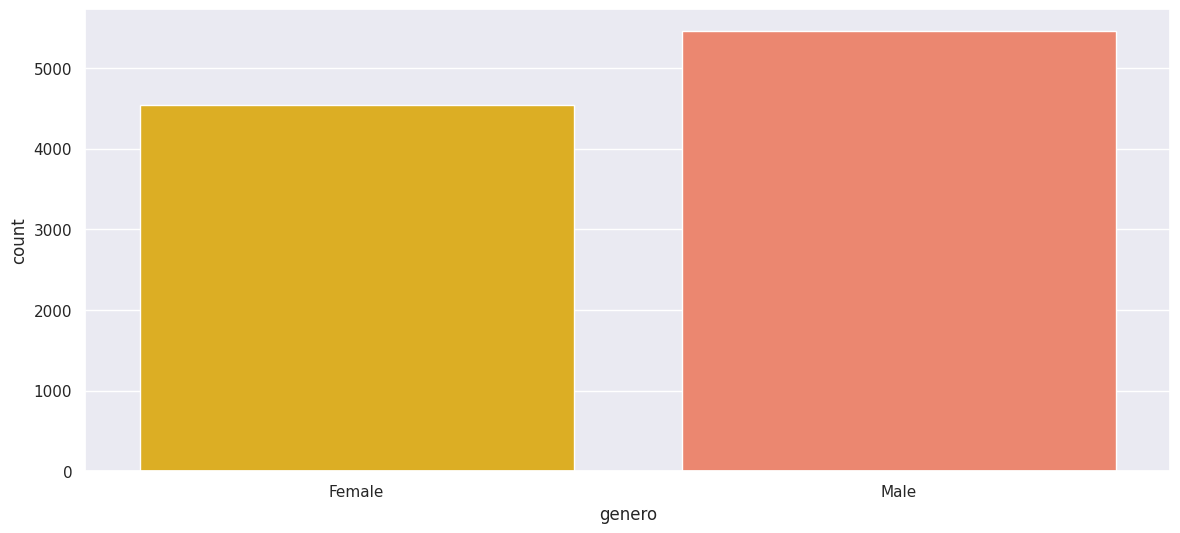

In [79]:
sns.countplot(x= df4['genero'], palette= categorical_palette);

In [80]:
pd.DataFrame({'absoluto': df4['genero'].value_counts(), 'percentual (%)': df4['genero'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
Male,5457,54.57
Female,4543,45.43


#### *tem_cartao_credito*

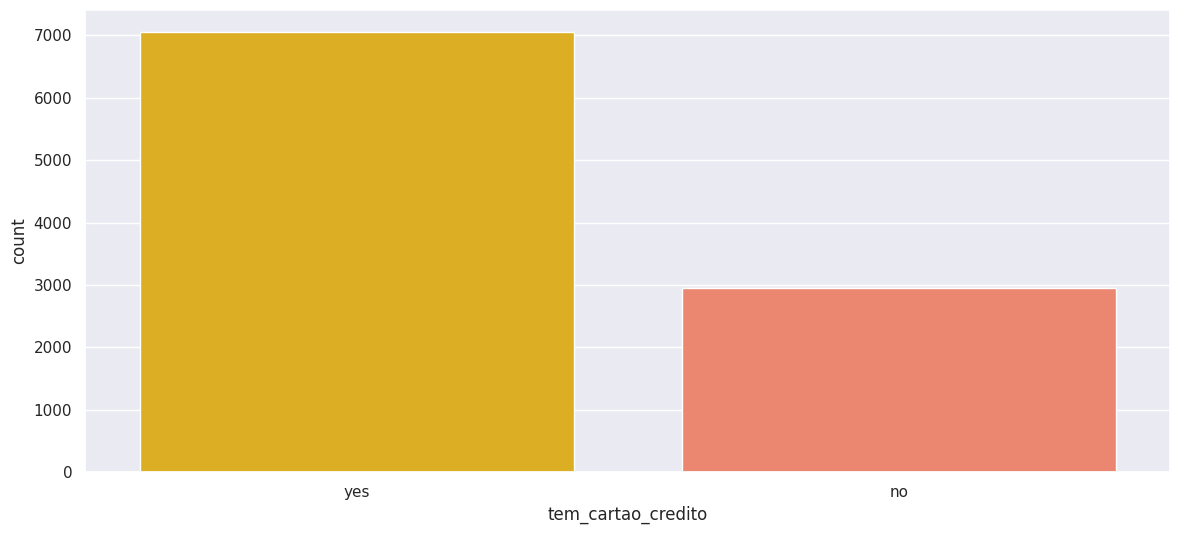

In [81]:
sns.countplot(x= df4['tem_cartao_credito'], palette= categorical_palette);

In [82]:
pd.DataFrame({'absoluto': df4['tem_cartao_credito'].value_counts(), 'percentual (%)': df4['tem_cartao_credito'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
yes,7055,70.55
no,2945,29.45


#### *membro_ativo*

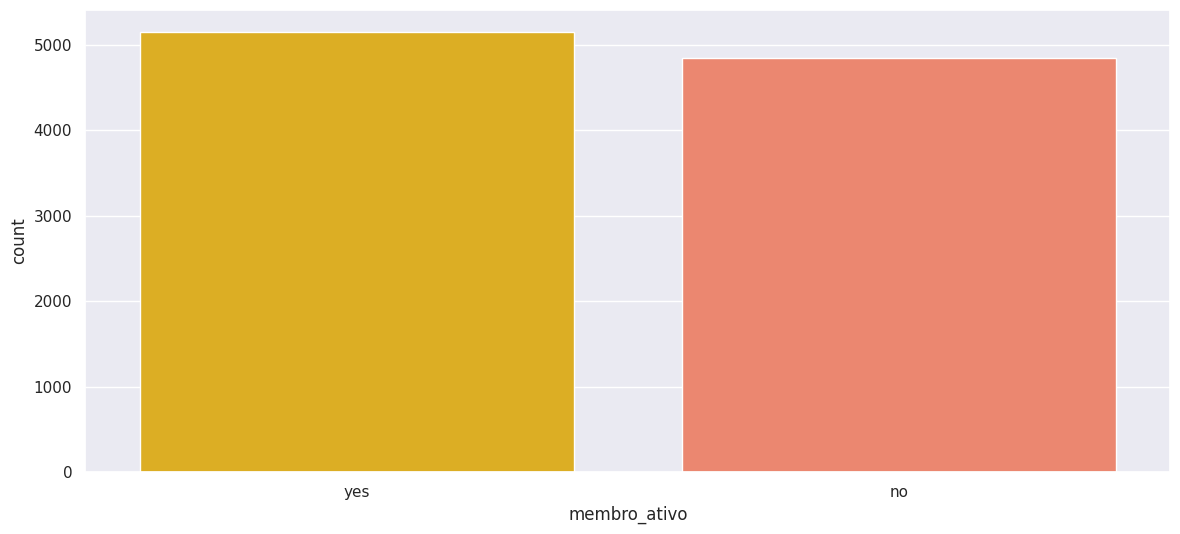

In [83]:
sns.countplot(x= df4['membro_ativo'], palette= categorical_palette);

In [84]:
pd.DataFrame({'absoluto': df4['membro_ativo'].value_counts(), 'percentual (%)': df4['membro_ativo'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
yes,5151,51.51
no,4849,48.49


#### *escala_fico*

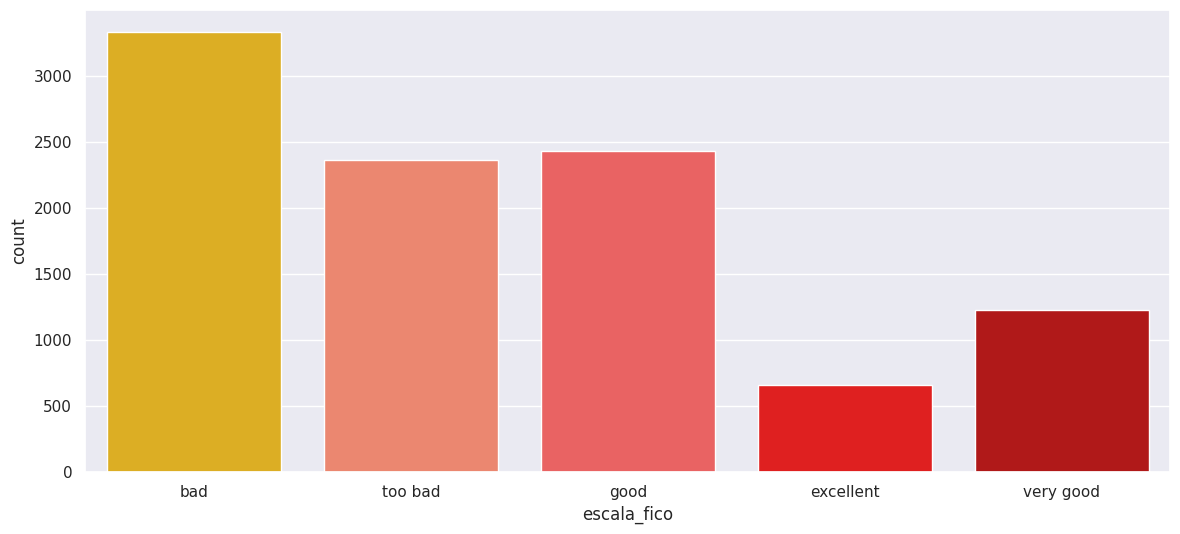

In [85]:
sns.countplot(x= df4['escala_fico'], palette= categorical_palette);

In [86]:
pd.DataFrame({'absoluto': df4['escala_fico'].value_counts(), 'percentual (%)': df4['escala_fico'].value_counts(normalize= True) * 100})

,absoluto,percentual (%)
bad,3331,33.31
good,2428,24.28
too bad,2362,23.62
very good,1224,12.24
excellent,655,6.55


## Bivariate and Multivariate Analysis

## Note:
Informações Importantes:


Próxima versão: 
- Adicionar 1º e 3º quartil na função numerical_estatistic_statistical;
- Interpretação Estatística e de Negócio na Análise Univariada;
- Análise Bivariada com insights das hipóteses criadas e Análise Multivariada;

# Feature Engineering II (Data Preparation)

In [ ]:
df5 = df4.copy()

In [ ]:
data_for_filtering = df4.copy()

## Data Filtering

In [ ]:
columns_to_delete = ['numero_linha','id_cliente','sobrenome']
filtered_data = data_for_filtering.drop(columns_to_delete, axis= 1)

In [ ]:
filtered_data.head()

## Splitting Dataframe into Training and Test Dataset

In [ ]:
X = filtered_data.drop(columns = ['Churn'])
y = filtered_data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state= 42)

## Scaling (only Train data)

### Standardization (or  X-score Normalization)

- Na Análise Univariada é possível verificar que não temos nenhuma distribuição normal nas variáveis numéricas, logo será descartado o processo de normalização.

### Normalization (or Rescaling)

In [ ]:
robust_scaler = RobustScaler() #rescala para variáveis numéricas com distribuições não gaussianas que possuem outliers (score_credito, idade, numero_de_contas)
min_max_scaler = MinMaxScaler() #rescala para variáveis numéricas com distribuições não gaussianas que não possuem outliers (saldo, salario_estimado, tempo_permanencia)

#### 'score_credito'

In [ ]:
X_train['score_credito'] = robust_scaler.fit_transform(X_train[['score_credito']].values)

outfile = open('/home/rnglinux/projetos/Churn-Predict/parameters/score_credito_scaler.pkl', 'wb')
pickle.dump(robust_scaler, outfile)
outfile.close()

#### 'idade'

In [ ]:
X_train['idade'] = robust_scaler.fit_transform(X_train[['idade']].values)

outfile = open('/home/rnglinux/projetos/Churn-Predict/parameters/idade_scaler.pkl', 'wb')
pickle.dump(robust_scaler, outfile)
outfile.close()

#### 'saldo'

In [ ]:
X_train['saldo'] = min_max_scaler.fit_transform(X_train[['saldo']].values)

outfile = open('/home/rnglinux/projetos/Churn-Predict/parameters/saldo_scaler.pkl', 'wb')
pickle.dump(min_max_scaler, outfile)
outfile.close()

#### 'salario_estimado'

In [ ]:
X_train['salario_estimado'] = min_max_scaler.fit_transform(X_train[['salario_estimado']].values)

outfile = open('/home/rnglinux/projetos/Churn-Predict/parameters/salario_estimado_scaler.pkl', 'wb')
pickle.dump(min_max_scaler, outfile)
outfile.close()

#### 'tempo_permanencia'

In [ ]:
X_train['tempo_permanencia'] = min_max_scaler.fit_transform(X_train[['tempo_permanencia']].values)

outfile = open('/home/rnglinux/projetos/Churn-Predict/parameters/tempo_permanencia_scaler.pkl', 'wb')
pickle.dump(min_max_scaler, outfile)
outfile.close()

### Encoding

In [ ]:
label_encoder = LabelEncoder() # troca de categorias por números de 1 a n. (geografia, gênero)
#E transformação comum para variáveis tem_cartao_credito, membro_ativo e Churn, Yes = 1 e No = 0.

#### 'geografia'

In [ ]:
X_train['geografia'] = label_encoder.fit_transform(X_train['geografia'].values)

outfile = open('/home/rnglinux/projetos/Churn-Predict/parameters/geografia.pkl', 'wb')
pickle.dump(label_encoder, outfile)
outfile.close()

#### 'gênero'

In [ ]:
X_train['genero'] = label_encoder.fit_transform(X_train['genero'].values)

outfile = open('/home/rnglinux/projetos/Churn-Predict/parameters/genero.pkl', 'wb')
pickle.dump(label_encoder, outfile)
outfile.close()

#### 'tem_cartao_credito'

In [ ]:
X_train['tem_cartao_credito'] = X_train['tem_cartao_credito'].apply(lambda x: 1 if x == 'yes' else 0)

#### 'membro_ativo'

In [ ]:
X_train['membro_ativo'] = X_train['membro_ativo'].apply(lambda x: 1 if x == 'yes' else 0)

#### Response Variable (Churn)

In [ ]:
y_train = y_train.apply(lambda x: 1 if x == 'yes' else 0)

In [ ]:
X_train.head()

In [ ]:
y_train.head()

## Balancing Response Variable (only Train Data)

In [ ]:
#y_train
sns.countplot(x= y_train, palette= "light:b_r");

- Como a variável resposta está desbalanceada, aplico uma técnica (algoritmo) que irá balancear os dados e evitar enviesamento do modelo.

In [ ]:
X_train.head()

In [ ]:
# Over-Sampling na variável resposta dos dados de treino 
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

sns.countplot(x= y_train_resampled, palette= "light:b_r");

## Note:
- Como a técnica SMOTE consiste em sintetizar novos dados a partir de dados já existentes, alguns dados das colunas 'id_cliente' e 'sobrenome' iriam se repetir. Como também são colunas não relevantes para o aprendizado do modelo, e é possível resgatá-las posteriormente pela indexação, decide excluí-las na Filtragem dos Dados.
- Ao escalar os dados usa-se métricas que são definidas por todo o conjunto de dados, então decidi dividir os dados de treino e teste antes de escalar, pois assim, eu teria dois conjuntos de dados, com métricas únicas para cada conjunto, anulando o enviesamento do modelo. 
		Ex.: A normalização MinMaxScaler utiliza o valor mínimo e máximo do conjunto de dados. Se a normalização tivesse sido feita antes da divisão dos dados em conjuntos de treino e teste, a normalização dos dois conjuntos teriam o mesmo padrão escalar, de um único conjunto, pois iriam dividir os elementos mínimos e máximo, logo estaria injetando informações futuras no conjunto de dados de treinamneto, e assim, enviesando o modelo. Com normalização realizada depois da divisão dos dados em treino e teste, os valores mínimo e máximo seriam únicos para cada conjunto, assim, isolando os dados de treino com os dados de teste, evitando o enviesamento do modelo.

# Feature Selection

In [ ]:
df6 = df5.copy()

## Boruta Feature Selector

In [ ]:
X_train_boruta= X_train_resampled.values
y_train_boruta = y_train_resampled.values.ravel()

In [ ]:
# Intanciando RandomForestRegressor
random_forest = RandomForestRegressor(n_jobs=-1)

# Intanciando Boruta
boruta = BorutaPy(random_forest, n_estimators='auto', verbose= 2, random_state= 42).fit(X_train_boruta, y_train_boruta)

### Best Features from Boruta 

In [ ]:
columns_selected = boruta.support_.tolist()

columns_selected_boruta = X_train_resampled.iloc[:, columns_selected].columns.to_list()

columns_not_selected_boruta = list(np.setdiff1d(X_train_resampled.columns, columns_selected_boruta))

In [ ]:
columns_selected_boruta

In [ ]:
columns_not_selected_boruta

# Machine Learning and Model Metrics 

In [ ]:
df7 = df6.copy()

## Splitting Dataframe into Training and Test Dataset and Selecting Best Features to Model

In [ ]:
X_train_model = X_train_resampled[columns_selected_boruta]
y_train_model = y_train_resampled

X_test_model = X_test[columns_selected_boruta]
y_test_model = y_test

## Training and Testing -  Random Forest

In [ ]:
# Instanciando o Modelo
model = RandomForestClassifier(n_estimators= 1000, n_jobs=-1, random_state= 42)

# Treinando o modelo
model.fit(X_train_model, y_train_model)

outfile = open('/home/rnglinux/projetos/Churn-Predict/model/model_v1.pkl', 'wb')
pickle.dump(model, outfile)
outfile.close()

### Scaling and Balancing Data Test

In [ ]:
# Scaling Test Data

## 'score_credito'
X_test_model['score_credito'] = robust_scaler.transform(X_test_model[['score_credito']].values)

## 'idade'
X_test_model['idade'] = robust_scaler.transform(X_test_model[['idade']].values)

## 'tempo_permanencia'
X_test_model['tempo_permanencia'] = min_max_scaler.transform(X_test_model[['tempo_permanencia']].values)

## 'saldo'
X_test_model['saldo'] = min_max_scaler.transform(X_test_model[['saldo']].values)

## 'salario_estimado'
X_test_model['salario_estimado'] = min_max_scaler.transform(X_test_model[['salario_estimado']].values)

## 'numero de contas'
# Não precisa de trasformação

## Response Variable (Churn)
y_test_model = y_test_model.apply(lambda x: 1 if x == 'yes' else 0)

In [ ]:
# Over-Sampling na variável resposta dos dados de teste
X_test_resampled, y_test_resampled = SMOTE().fit_resample(X_test_model, y_test_model)

sns.countplot(x= y_test_resampled, palette= "light:b_r");

In [ ]:
X_test_model.head()

In [ ]:
y_test_model.head()

### Predict

In [ ]:
# Previsão com dados de teste
yhat_model = model.predict(X_test_model)

## Metrics

### Confusion Matrix

In [ ]:
matrix_absolute = confusion_matrix(y_test_model, yhat_model)
matrix_percentage = confusion_matrix(y_test_model, yhat_model, normalize= 'true')

print('- Matriz Absoluta')
print(matrix_absolute)

In [ ]:
print('- Matriz Percentual')
print(matrix_percentage)

In [ ]:
true_positive_abs = matrix_absolute[0][0]
false_negative_abs = matrix_absolute[0][1]
false_positive_abs = matrix_absolute[1][0]
true_negative_abs = matrix_absolute[1][1]

print(f'True Positive: {true_positive_abs}')
print(f'False Negative: {false_negative_abs}')
print(f'False Positive: {false_positive_abs}')
print(f'True Negative: {true_negative_abs}')

In [ ]:
true_positive_perc = matrix_percentage[0][0]
false_negative_perc = matrix_percentage[0][1]
false_positive_perc = matrix_percentage[1][0]
true_negative_perc = matrix_percentage[1][1]

print(f'True Positive: {true_positive_perc * 100 :.2f}%')
print(f'False Negative: {false_negative_perc * 100:.2f}%')
print(f'False Positive: {false_positive_perc * 100:.2f}%')
print(f'True Negative: {true_negative_perc * 100:.2f}%')

In [ ]:
# Métricas de Performance do Modelo
print(classification_report(y_test_model, yhat_model))

## Hypothetical Prediction

In [ ]:
hypothetical_client = pd.DataFrame({'score_credito':48.833333,
                                    'idade': -0.833333,
                                    'tempo_permanencia': 0.3,
                                    'saldo': 9670.907,
                                    'numero_de_contas': 1,
                                    'salario_estimado': 14637.930}, index=[0])

client_probability = model.predict_proba(hypothetical_client)
client_probability
print(f'A probabilidade do cliente hipotético de não recontratar o plano de conta do Top Bank é de {round(client_probability[:, 1][0] * 100, 2)}%')

## Note:
Para a próxima versão:
1. Multi-modelagem para definir o melhor modelo.
2. Estudar os melhores parâmetros para serem aplicados no modelo escolhido.
3. Definir as métrica mais importantes para o projeto.
3. Implementar Curva ROC.

# Business Translation

In [ ]:
df8 = df7.copy()

## What is Top Bank's current Churn rate?

- Foi respondida na análise univariada da variável resposta. 20.37% de Churn Rate.

In [ ]:
sns.countplot(x=df4['Churn'], palette= "light:b_r");

In [ ]:
percentage_no_churn = df4[['id_cliente', 'Churn']].loc[df4['Churn'] == 'no'].shape[0] / df4.shape[0] * 100
percentage_yes_churn = df4[['id_cliente', 'Churn']].loc[df4['Churn'] == 'yes'].shape[0] / df4.shape[0] * 100
print(f'R: Clientes que irão dar Churn correspondem a {percentage_yes_churn:.2f}% da base de dados e clientes que não irão dar Churn correspondem a {percentage_no_churn:.2f}% da base de dados.')

## How does the churn rate vary monthly?

- Será respondido no segundo ciclo.

## What is the performance of the model in classifying customers as churns?

    R: O modelo possui uma precisão de 68% nesse primeiro ciclo.

## What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?

- Será respondido no segundo ciclo.

# Deploy

## Note:
Próxima versão: criação da classe para deploy.

# Referências

- Alura - Lidando com desbalanceamente de dados (https://www.alura.com.br/artigos/lidando-com-desbalanceamento-dados#:~:text=%C3%89%20uma%20t%C3%A9cnica%20que%20consiste%20em%20aumentar%20a%20quantidade%20de,da%20classe%20com%20menor%20frequ%C3%AAncia)
- Imbalanced Learn - Over-sampling (https://imbalanced-learn.org/stable/over_sampling.html#from-random-over-sampling-to-smote-and-adasyn)